# Spaceship Titanic - V8 (V5 + Surgical Features + Diverse Ensemble)

**Base:** V5 = best LB 0.80874 (V2 features + TE bayésien, params manuels V2)

**V8 additions:**
1. **Cabin spatial features** — CabinNum is spatial position, nearby passengers share fate
2. **Group spending patterns** — max_spend_in_group, spend_rank_in_group
3. **Strong interactions** — CryoSleep×Age, Deck×Destination
4. **Diverse ensemble** — Add ExtraTrees + RandomForest to break >98% GBDT correlation

| V | CV | LB | Gap | Features |
|---|------|--------|------|----------|
| V2 | 0.81410 | 0.80710 | 0.0070 | 29 |
| V5 | 0.81767 | 0.80874 | 0.0089 | 32 |
| V8 | ? | ? | ? | ~38 |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import warnings, os

warnings.filterwarnings('ignore')

SEED = 42
N_FOLDS = 10
TARGET = 'Transported'

def seed_everything(seed=SEED):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything()
print('V8 Setup complete.')

V8 Setup complete.


In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_sub = pd.read_csv('../data/sample_submission.csv')

train['is_train'] = 1
test['is_train'] = 0
test[TARGET] = np.nan
df = pd.concat([train, test], axis=0, ignore_index=True)

spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
print(f'Combined: {df.shape}')

Combined: (12970, 15)


## V5 Base Features (identical)

In [3]:
# === V2 Feature Engineering (identical to V5) ===
df['_Group'] = df['PassengerId'].str.split('_').str[0].astype(int)
df['GroupSize'] = df.groupby('_Group')['PassengerId'].transform('count')
df['IsAlone'] = (df['GroupSize'] == 1).astype(int)

df['Deck'] = df['Cabin'].str.split('/').str[0]
df['CabinNum'] = df['Cabin'].str.split('/').str[1].astype(float)
df['Side'] = df['Cabin'].str.split('/').str[2]
df['CabinRegion'] = (df['CabinNum'] // 100).astype(float)

df['Surname'] = df['Name'].str.split().str[-1]
df['FamilySize'] = df.groupby('Surname')['PassengerId'].transform('count')
df.loc[df['Surname'].isna(), 'FamilySize'] = 1

df['CryoSleep'] = df['CryoSleep'].map({True: 1, False: 0, 'True': 1, 'False': 0})
df['VIP'] = df['VIP'].map({True: 1, False: 0, 'True': 1, 'False': 0})

# V2 Imputation
for col in spend_cols:
    mask = (df['CryoSleep'] == 1) & (df[col].isna())
    df.loc[mask, col] = 0
mask = (df['CryoSleep'].isna()) & (df[spend_cols].sum(axis=1) == 0)
df.loc[mask, 'CryoSleep'] = 1
mask = (df['CryoSleep'].isna()) & (df[spend_cols].sum(axis=1) > 0)
df.loc[mask, 'CryoSleep'] = 0

for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())
for col in df.select_dtypes(include=['object']).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

# V2 Spending
df['TotalSpend'] = df[spend_cols].sum(axis=1)
df['TotalSpend_log'] = np.log1p(df['TotalSpend'])
df['NoSpend'] = (df['TotalSpend'] == 0).astype(int)
df['NumServicesUsed'] = (df[spend_cols] > 0).sum(axis=1)
for col in spend_cols:
    df[f'{col}_log'] = np.log1p(df[col])
df['LuxurySpend'] = np.log1p(df['Spa'] + df['VRDeck'] + df['RoomService'])
df['BasicSpend'] = np.log1p(df['FoodCourt'] + df['ShoppingMall'])

df['AgeGroup'] = pd.cut(df['Age'], bins=[0,5,12,18,30,50,80], labels=[0,1,2,3,4,5]).astype(float)
df['IsChild'] = (df['Age'] < 18).astype(float)
df['CryoSleep_NoSpend'] = ((df['CryoSleep'] == 1) & (df['TotalSpend'] == 0)).astype(int)

df['GroupSpend_mean'] = df.groupby('_Group')['TotalSpend'].transform('mean')
df['GroupSpend_mean_log'] = np.log1p(df['GroupSpend_mean'])

for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
    le = LabelEncoder()
    df[col + '_le'] = le.fit_transform(df[col].astype(str))
for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
    freq = df[col].value_counts(normalize=True)
    df[col + '_freq'] = df[col].map(freq)

print('V2 base features done.')

V2 base features done.


In [4]:
# === V5 Target Encoding (identical) ===
te_cols = ['HomePlanet', 'Destination', 'Deck']
SMOOTHING = 20

train_idx = df[df['is_train'] == 1].index
test_idx = df[df['is_train'] == 0].index

y_for_te = df.loc[train_idx, TARGET].map({True: 1.0, False: 0.0, 1: 1.0, 0: 0.0}).astype(float)
df.loc[train_idx, '_target_float'] = y_for_te.values
global_mean = float(y_for_te.mean())

kf_te = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for col in te_cols:
    col_te = f'{col}_te'
    df[col_te] = global_mean
    
    for fold_train, fold_val in kf_te.split(train_idx, y_for_te):
        fold_train_idx = train_idx[fold_train]
        fold_val_idx = train_idx[fold_val]
        stats = df.loc[fold_train_idx].groupby(col)['_target_float'].agg(['mean', 'count'])
        stats['te'] = (stats['count'] * stats['mean'] + SMOOTHING * global_mean) / (stats['count'] + SMOOTHING)
        mapped = df.loc[fold_val_idx, col].map(stats['te']).fillna(global_mean)
        df.loc[fold_val_idx, col_te] = mapped.values
    
    stats = df.loc[train_idx].groupby(col)['_target_float'].agg(['mean', 'count'])
    stats['te'] = (stats['count'] * stats['mean'] + SMOOTHING * global_mean) / (stats['count'] + SMOOTHING)
    mapped = df.loc[test_idx, col].map(stats['te']).fillna(global_mean)
    df.loc[test_idx, col_te] = mapped.values

df.drop('_target_float', axis=1, inplace=True)
print('V5 TE done.')

V5 TE done.


## V8 New Features

In [5]:
# === NEW 1: Cabin spatial features ===
# CabinNum is position on ship — nearby passengers share fate
# Finer spatial region (CabinRegion = //100, this = //50 for more resolution)
df['CabinRegion_fine'] = (df['CabinNum'] // 50).astype(float)

# Group cabin spatial stats (how spread out is the group on the ship?)
df['GroupCabinNum_mean'] = df.groupby('_Group')['CabinNum'].transform('mean')
df['CabinNum_diff_group'] = df['CabinNum'] - df['GroupCabinNum_mean']

print('Cabin spatial features done.')
print(f"  CabinRegion_fine: {df['CabinRegion_fine'].nunique()} unique values")
print(f"  CabinNum_diff_group: mean={df['CabinNum_diff_group'].mean():.2f}, std={df['CabinNum_diff_group'].std():.2f}")

Cabin spatial features done.
  CabinRegion_fine: 38 unique values
  CabinNum_diff_group: mean=-0.00, std=99.57


In [6]:
# === NEW 2: Group spending patterns ===
# Max spender in group (computed on train+test = safe)
df['GroupSpend_max'] = df.groupby('_Group')['TotalSpend'].transform('max')
df['GroupSpend_max_log'] = np.log1p(df['GroupSpend_max'])

# Spend rank within group (pct rank: 0=lowest, 1=highest)
df['SpendRank_in_group'] = df.groupby('_Group')['TotalSpend'].rank(pct=True)
# For solo passengers, rank is always 1.0 — make it 0.5 (neutral)
df.loc[df['GroupSize'] == 1, 'SpendRank_in_group'] = 0.5

print('Group spending patterns done.')
print(f"  SpendRank_in_group: mean={df['SpendRank_in_group'].mean():.3f}")

Group spending patterns done.


  SpendRank_in_group: mean=0.582


In [7]:
# === NEW 3: Strong interactions ===
# CryoSleep × Age: cryo children behave differently than cryo adults
df['Cryo_x_Age'] = df['CryoSleep'] * df['Age']
df['Cryo_x_IsChild'] = df['CryoSleep'] * df['IsChild']

# Deck × Destination: frequency encode (low risk, computed on train+test)
df['DeckDest'] = df['Deck'] + '_' + df['Destination']
freq = df['DeckDest'].value_counts(normalize=True)
df['DeckDest_freq'] = df['DeckDest'].map(freq)

print('Interactions done.')
print(f"  DeckDest unique: {df['DeckDest'].nunique()} categories")

Interactions done.
  DeckDest unique: 23 categories


In [8]:
# === DEFINE FEATURES ===
drop_cols = [
    'PassengerId', 'Name', 'Cabin', 'Surname', 'is_train', TARGET,
    'HomePlanet', 'Destination', 'Deck', 'Side', 'DeckDest',
    '_Group', 'CabinNum',
    'TotalSpend', 'GroupSpend_mean', 'GroupSpend_max', 'GroupCabinNum_mean',
] + spend_cols

features = [c for c in df.columns if c not in drop_cols]
print(f'V8 features: {len(features)} (V5: 32 + 7 new)')
print()

v5_features = [
    'Age', 'AgeGroup', 'BasicSpend', 'CabinRegion', 'CryoSleep',
    'CryoSleep_NoSpend', 'Deck_freq', 'Deck_le', 'Deck_te',
    'Destination_freq', 'Destination_le', 'Destination_te', 'FamilySize',
    'FoodCourt_log', 'GroupSize', 'GroupSpend_mean_log', 'HomePlanet_freq',
    'HomePlanet_le', 'HomePlanet_te', 'IsAlone', 'IsChild', 'LuxurySpend',
    'NoSpend', 'NumServicesUsed', 'RoomService_log', 'ShoppingMall_log',
    'Side_freq', 'Side_le', 'Spa_log', 'TotalSpend_log', 'VIP', 'VRDeck_log'
]

for i, f in enumerate(sorted(features)):
    marker = ' *** NEW' if f not in v5_features else ''
    print(f'  {i+1:2d}. {f}{marker}')

V8 features: 39 (V5: 32 + 7 new)

   1. Age
   2. AgeGroup
   3. BasicSpend
   4. CabinNum_diff_group *** NEW
   5. CabinRegion
   6. CabinRegion_fine *** NEW
   7. CryoSleep
   8. CryoSleep_NoSpend
   9. Cryo_x_Age *** NEW
  10. Cryo_x_IsChild *** NEW
  11. DeckDest_freq *** NEW
  12. Deck_freq
  13. Deck_le
  14. Deck_te
  15. Destination_freq
  16. Destination_le
  17. Destination_te
  18. FamilySize
  19. FoodCourt_log
  20. GroupSize
  21. GroupSpend_max_log *** NEW
  22. GroupSpend_mean_log
  23. HomePlanet_freq
  24. HomePlanet_le
  25. HomePlanet_te
  26. IsAlone
  27. IsChild
  28. LuxurySpend
  29. NoSpend
  30. NumServicesUsed
  31. RoomService_log
  32. ShoppingMall_log
  33. Side_freq
  34. Side_le
  35. Spa_log
  36. SpendRank_in_group *** NEW
  37. TotalSpend_log
  38. VIP
  39. VRDeck_log


In [9]:
# Split
train_df = df[df['is_train'] == 1].copy()
test_df = df[df['is_train'] == 0].copy()

X = train_df[features].values
y = train_df[TARGET].astype(int).values
X_test = test_df[features].values

print(f'X: {X.shape}, y: {y.shape}, X_test: {X_test.shape}')
print(f'Target mean: {np.mean(y):.4f}')

X: (8693, 39), y: (8693,), X_test: (4277, 39)
Target mean: 0.5036


## Level 0: GBDT Models (V2 manual params)

In [10]:
kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

# === LightGBM (V2 params) ===
lgb_params = {
    'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt',
    'num_leaves': 20, 'learning_rate': 0.03, 'feature_fraction': 0.7,
    'bagging_fraction': 0.7, 'bagging_freq': 5, 'min_child_samples': 30,
    'reg_alpha': 0.5, 'reg_lambda': 2.0, 'max_depth': 5,
    'n_estimators': 5000, 'verbose': -1, 'n_jobs': -1, 'random_state': SEED,
}

oof_lgb = np.zeros(len(X))
test_lgb = np.zeros(len(X_test))
fi_lgb = np.zeros(len(features))

for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(X[tr_idx], y[tr_idx], eval_set=[(X[val_idx], y[val_idx])],
              callbacks=[lgb.early_stopping(200), lgb.log_evaluation(0)])
    oof_lgb[val_idx] = model.predict_proba(X[val_idx])[:, 1]
    test_lgb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    fi_lgb += model.feature_importances_ / N_FOLDS

lgb_acc = accuracy_score(y, (oof_lgb > 0.5).astype(int))
print(f'LightGBM CV: {lgb_acc:.5f}')

Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[357]	valid_0's binary_logloss: 0.390056
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[660]	valid_0's binary_logloss: 0.358409
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[361]	valid_0's binary_logloss: 0.355893
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[635]	valid_0's binary_logloss: 0.415072
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[596]	valid_0's binary_logloss: 0.3563
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[675]	valid_0's binary_logloss: 0.369467
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[375]	valid_0's binary_logloss: 0.357012
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[461]	valid_0's binary_logloss: 0.367366
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[307]	valid_0's binary_logloss: 0.386641
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[490]	valid_0's binary_logloss: 0.396569
LightGBM CV: 0.81675


In [11]:
# === XGBoost (V2 params) ===
xgb_params = {
    'objective': 'binary:logistic', 'eval_metric': 'logloss',
    'max_depth': 4, 'learning_rate': 0.03, 'subsample': 0.7,
    'colsample_bytree': 0.7, 'min_child_weight': 10,
    'reg_alpha': 0.5, 'reg_lambda': 2.0, 'gamma': 0.1,
    'n_estimators': 5000, 'early_stopping_rounds': 200,
    'tree_method': 'hist', 'random_state': SEED, 'verbosity': 0,
}

oof_xgb = np.zeros(len(X))
test_xgb = np.zeros(len(X_test))

for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X[tr_idx], y[tr_idx], eval_set=[(X[val_idx], y[val_idx])], verbose=0)
    oof_xgb[val_idx] = model.predict_proba(X[val_idx])[:, 1]
    test_xgb += model.predict_proba(X_test)[:, 1] / N_FOLDS

xgb_acc = accuracy_score(y, (oof_xgb > 0.5).astype(int))
print(f'XGBoost CV:  {xgb_acc:.5f}')

XGBoost CV:  0.81755


In [12]:
# === CatBoost (V2 params) ===
oof_cb = np.zeros(len(X))
test_cb = np.zeros(len(X_test))

for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
    model = CatBoostClassifier(
        iterations=5000, learning_rate=0.03, depth=4, l2_leaf_reg=5.0,
        subsample=0.7, colsample_bylevel=0.7, min_data_in_leaf=30,
        random_seed=SEED, verbose=0, early_stopping_rounds=200, task_type='CPU',
    )
    model.fit(X[tr_idx], y[tr_idx], eval_set=(X[val_idx], y[val_idx]))
    oof_cb[val_idx] = model.predict_proba(X[val_idx])[:, 1]
    test_cb += model.predict_proba(X_test)[:, 1] / N_FOLDS

cb_acc = accuracy_score(y, (oof_cb > 0.5).astype(int))
print(f'CatBoost CV: {cb_acc:.5f}')

CatBoost CV: 0.81721


## Level 0: Non-GBDT Models (diversity)

In [13]:
# Scale features for sklearn models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# === ExtraTrees ===
oof_et = np.zeros(len(X))
test_et = np.zeros(len(X_test))

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_scaled, y)):
    model = ExtraTreesClassifier(
        n_estimators=1000, max_depth=12, min_samples_leaf=10,
        max_features=0.7, random_state=SEED, n_jobs=-1,
    )
    model.fit(X_scaled[tr_idx], y[tr_idx])
    oof_et[val_idx] = model.predict_proba(X_scaled[val_idx])[:, 1]
    test_et += model.predict_proba(X_test_scaled)[:, 1] / N_FOLDS

et_acc = accuracy_score(y, (oof_et > 0.5).astype(int))
print(f'ExtraTrees CV: {et_acc:.5f}')

ExtraTrees CV: 0.80847


In [14]:
# === RandomForest ===
oof_rf = np.zeros(len(X))
test_rf = np.zeros(len(X_test))

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_scaled, y)):
    model = RandomForestClassifier(
        n_estimators=1000, max_depth=12, min_samples_leaf=10,
        max_features=0.7, random_state=SEED, n_jobs=-1,
    )
    model.fit(X_scaled[tr_idx], y[tr_idx])
    oof_rf[val_idx] = model.predict_proba(X_scaled[val_idx])[:, 1]
    test_rf += model.predict_proba(X_test_scaled)[:, 1] / N_FOLDS

rf_acc = accuracy_score(y, (oof_rf > 0.5).astype(int))
print(f'RandomForest CV: {rf_acc:.5f}')

RandomForest CV: 0.80824


In [15]:
# === Correlation analysis ===
print('=== Individual Model Scores ===')
print(f'LightGBM:     {lgb_acc:.5f}')
print(f'XGBoost:      {xgb_acc:.5f}')
print(f'CatBoost:     {cb_acc:.5f}')
print(f'ExtraTrees:   {et_acc:.5f}')
print(f'RandomForest: {rf_acc:.5f}')

models_oof = {'LGB': oof_lgb, 'XGB': oof_xgb, 'CB': oof_cb, 'ET': oof_et, 'RF': oof_rf}
names = list(models_oof.keys())

print('\n=== OOF Correlations ===')
for i in range(len(names)):
    for j in range(i+1, len(names)):
        corr = np.corrcoef(models_oof[names[i]], models_oof[names[j]])[0, 1]
        marker = ' <-- diverse!' if corr < 0.95 else ''
        print(f'  {names[i]}-{names[j]}: {corr:.4f}{marker}')

=== Individual Model Scores ===
LightGBM:     0.81675
XGBoost:      0.81755
CatBoost:     0.81721
ExtraTrees:   0.80847
RandomForest: 0.80824

=== OOF Correlations ===
  LGB-XGB: 0.9933
  LGB-CB: 0.9887
  LGB-ET: 0.9734
  LGB-RF: 0.9800
  XGB-CB: 0.9878
  XGB-ET: 0.9705
  XGB-RF: 0.9763
  CB-ET: 0.9683
  CB-RF: 0.9738
  ET-RF: 0.9866


## Ensemble: Multiple Strategies

In [16]:
# Strategy 1: Simple average (all 5 models)
oof_avg5 = (oof_lgb + oof_xgb + oof_cb + oof_et + oof_rf) / 5
avg5_acc = accuracy_score(y, (oof_avg5 > 0.5).astype(int))

# Strategy 2: Simple average (3 GBDT only, like V5)
oof_avg3 = (oof_lgb + oof_xgb + oof_cb) / 3
avg3_acc = accuracy_score(y, (oof_avg3 > 0.5).astype(int))

# Strategy 3: Weighted — give less weight to weaker models
# GBDT: 0.25 each, ET/RF: 0.125 each (total = 1.0)
oof_weighted = 0.25 * oof_lgb + 0.25 * oof_xgb + 0.25 * oof_cb + 0.125 * oof_et + 0.125 * oof_rf
weighted_acc = accuracy_score(y, (oof_weighted > 0.5).astype(int))

# Strategy 4: Majority voting (5 models)
votes5 = ((oof_lgb > 0.5).astype(int) + (oof_xgb > 0.5).astype(int) + 
          (oof_cb > 0.5).astype(int) + (oof_et > 0.5).astype(int) + (oof_rf > 0.5).astype(int))
vote5_acc = accuracy_score(y, (votes5 >= 3).astype(int))

print('=== Ensemble Results ===')
print(f'3-GBDT Average:    {avg3_acc:.5f}')
print(f'5-Model Average:   {avg5_acc:.5f}')
print(f'5-Model Weighted:  {weighted_acc:.5f}')
print(f'5-Model Voting:    {vote5_acc:.5f}')

=== Ensemble Results ===
3-GBDT Average:    0.82043
5-Model Average:   0.81916
5-Model Weighted:  0.82112
5-Model Voting:    0.81905


In [17]:
# Find best ensemble strategy and generate submission
results = {
    '3-GBDT Avg': (avg3_acc, (test_lgb + test_xgb + test_cb) / 3),
    '5-Model Avg': (avg5_acc, (test_lgb + test_xgb + test_cb + test_et + test_rf) / 5),
    '5-Model Weighted': (weighted_acc, 0.25*test_lgb + 0.25*test_xgb + 0.25*test_cb + 0.125*test_et + 0.125*test_rf),
}

best_name = max(results, key=lambda k: results[k][0])
best_acc = results[best_name][0]
best_test_proba = results[best_name][1]

print(f'Best ensemble: {best_name} (CV: {best_acc:.5f})')
print(f'\n=== VERSION COMPARISON ===')
print(f'V2:  CV 0.81410 | LB 0.80710 | 29 feat | 3 GBDT avg')
print(f'V5:  CV 0.81767 | LB 0.80874 | 32 feat | 3 GBDT avg')
print(f'V8:  CV {best_acc:.5f} | LB TBD   | {len(features)} feat | {best_name}')

Best ensemble: 5-Model Weighted (CV: 0.82112)

=== VERSION COMPARISON ===
V2:  CV 0.81410 | LB 0.80710 | 29 feat | 3 GBDT avg
V5:  CV 0.81767 | LB 0.80874 | 32 feat | 3 GBDT avg
V8:  CV 0.82112 | LB TBD   | 39 feat | 5-Model Weighted


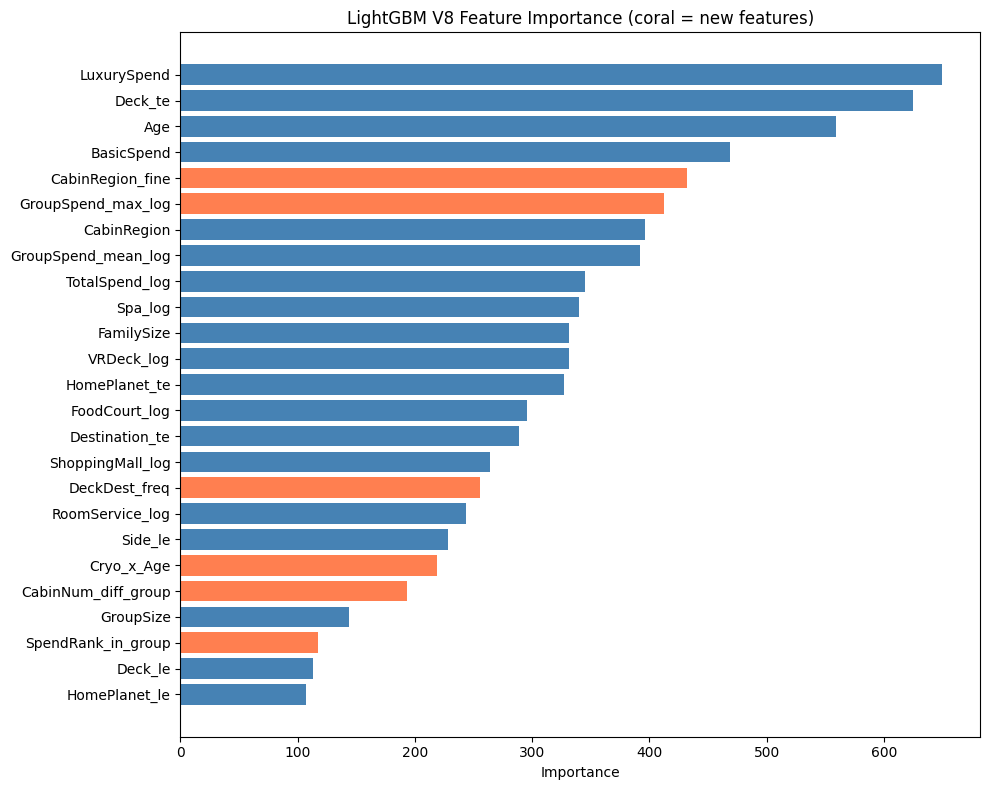

In [18]:
# Feature importance (LightGBM)
fi_df = pd.DataFrame({'feature': features, 'importance': fi_lgb})
fi_df = fi_df.sort_values('importance', ascending=True).tail(25)

colors = ['coral' if f not in v5_features else 'steelblue' for f in fi_df['feature']]
plt.figure(figsize=(10, 8))
plt.barh(fi_df['feature'], fi_df['importance'], color=colors)
plt.title(f'LightGBM V8 Feature Importance (coral = new features)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [19]:
# Save all promising submissions
for name, (acc, test_proba) in results.items():
    safe_name = name.replace(' ', '_').replace('-', '').lower()
    preds = (test_proba > 0.5)
    sub = pd.DataFrame({
        'PassengerId': test_df['PassengerId'].values,
        'Transported': preds.astype(bool)
    })
    fname = f'../submissions/submission_v8_{safe_name}.csv'
    sub.to_csv(fname, index=False)
    print(f'{name} (CV {acc:.5f}): {preds.sum()} True ({preds.mean():.4f}) -> {fname}')

# Also save the best as main v8
final_preds = (best_test_proba > 0.5)
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'].values,
    'Transported': final_preds.astype(bool)
})
submission.to_csv('../submissions/submission_v8.csv', index=False)

assert submission.shape[0] == sample_sub.shape[0]
assert list(submission.columns) == list(sample_sub.columns)

print(f'\nMain submission: submission_v8.csv ({best_name})')
print(submission['Transported'].value_counts(normalize=True))

3-GBDT Avg (CV 0.82043): 2217 True (0.5184) -> ../submissions/submission_v8_3gbdt_avg.csv
5-Model Avg (CV 0.81916): 2198 True (0.5139) -> ../submissions/submission_v8_5model_avg.csv
5-Model Weighted (CV 0.82112): 2213 True (0.5174) -> ../submissions/submission_v8_5model_weighted.csv

Main submission: submission_v8.csv (5-Model Weighted)
Transported
True     0.517419
False    0.482581
Name: proportion, dtype: float64
